In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
plt.style.use('../peptidome.mplstyle')
from lib.plotting import model_labels as labels

datadir = '/media/andreas/data/Dropbox (Princeton)/data/peptidome/maxent'

/tmp/ipykernel_109205/3978547414.py:105: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  coincidence_probs = pd.read_csv(f'{datadir}/Human_k9_coincidences.csv', index_col=0, squeeze=True)


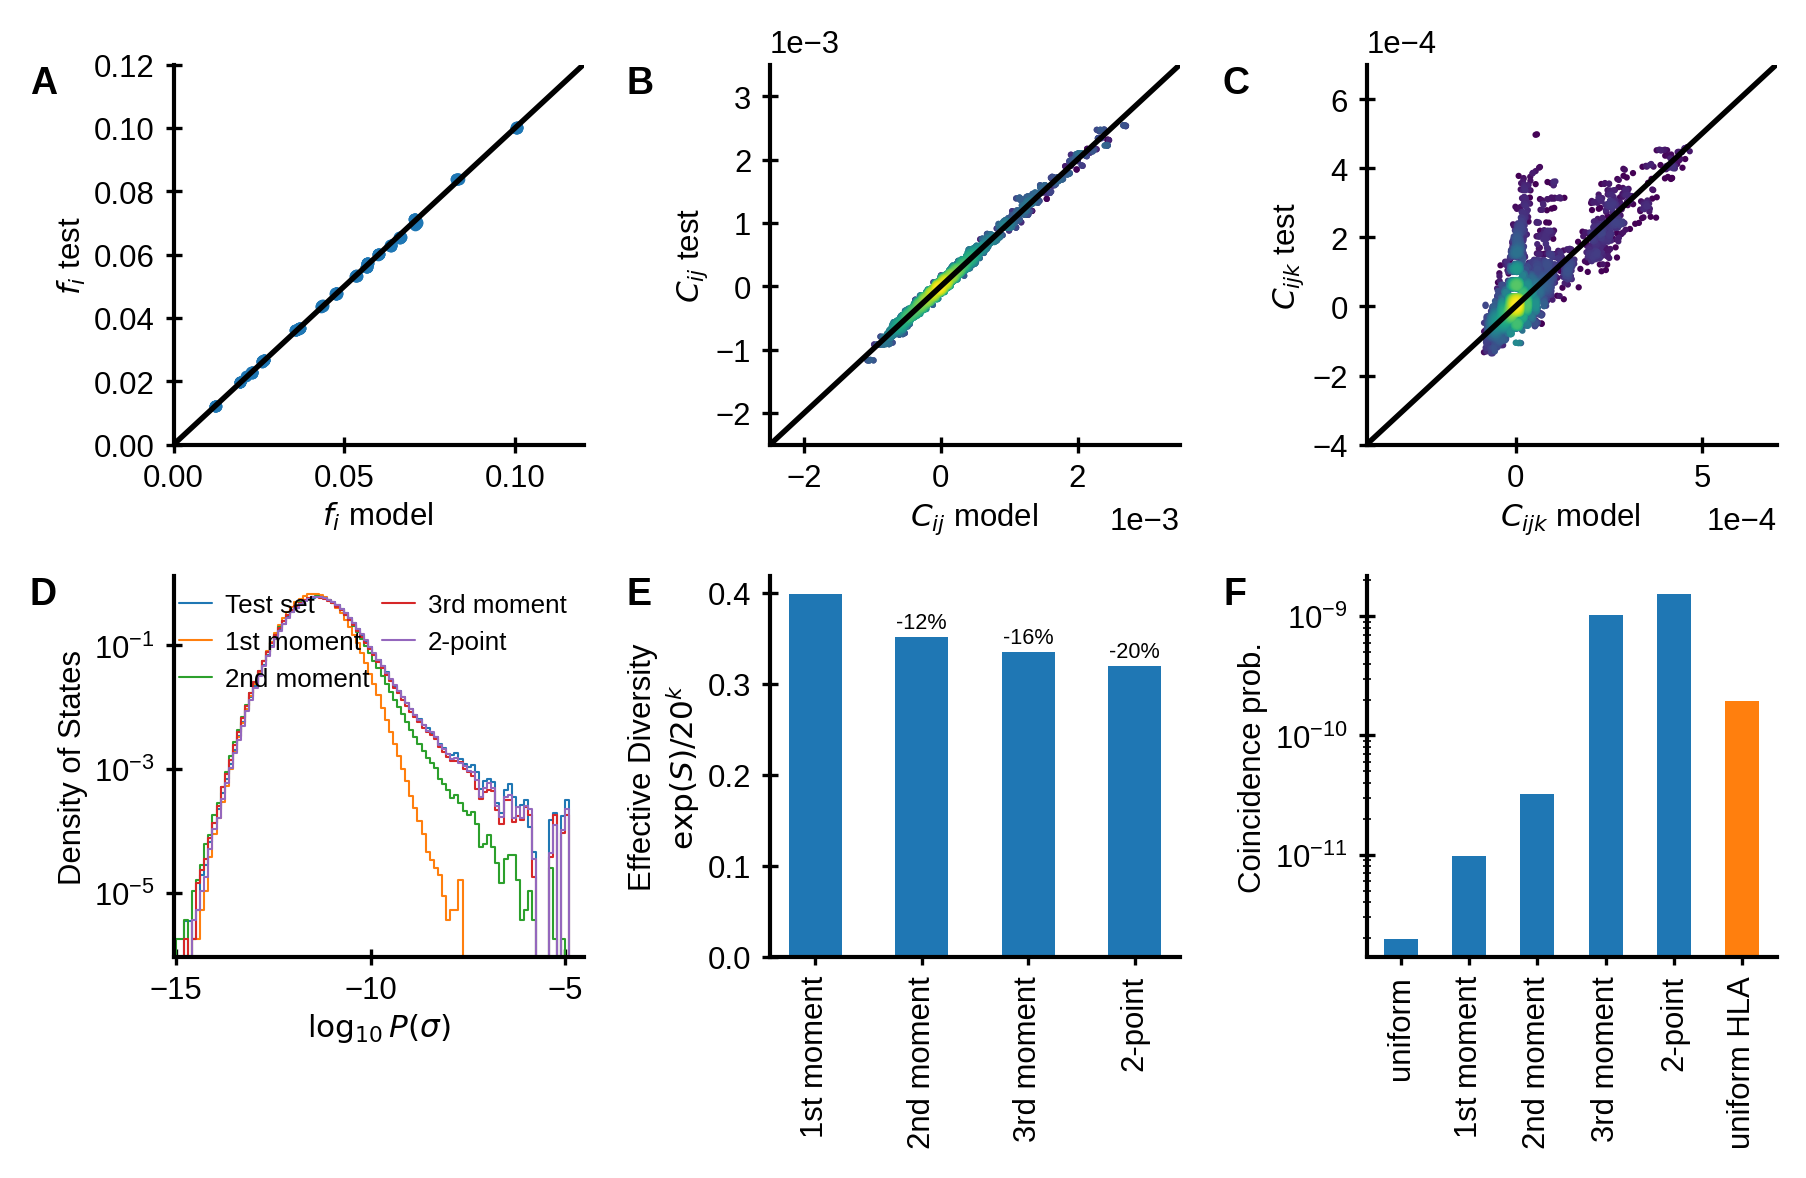

In [13]:
k = 9
fig, axes = plt.subplots(figsize=(6.1, 4.0), ncols=3, nrows=2)

labels_dict = {'uniform' : 'uniform',
          'independent' : '1st moment',
          'ncov' : '2nd moment',
          'nskew' : '3rd moment',
          'nskewfcov' : '2-point',
          'train' : 'data',
          'test' : 'Test set',
          'uniform HLA': 'uniform HLA'
         }

## observables
observables = ['fi', 'cij', 'cijk']
observables_dict = {key: dict() for key in observables}
datasets = ['test', 'model']
paths = [f'{datadir}/Human_test_k9_observables.npz',
        f'{datadir}/Human_nskewfcov_k9_observables.npz']

for i, dataset in enumerate(datasets):
    params = np.load(paths[i])
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

for j, (observable, label, lims, flattener) in enumerate([('fi', '$f_i$', (0, 0.12), np.ravel),
                                               ('cij', '$C_{ij}$', (-0.0025, 0.0035), flatten_ij),
                                               ('cijk', '$C_{ijk}$', (-4e-4, 7e-4), flatten_ijk)]):
    ax = axes[0, j]
    if observable in ['cij', 'cijk']:
        plotting.density_scatter(flattener(observables_dict[observable][dataset]),
                                 flattener(observables_dict[observable]['test']),
                                 norm=colors.LogNorm(vmin=1),
                                 s=0.5,
                                 bins=50, ax=ax)
    else:
        ax.plot(flattener(observables_dict[observable][dataset]),
                flattener(observables_dict[observable]['test']),
                'o', ms=2 if observable == 'fi' else 1)

    ax.set_xlabel('%s model '%(label))
    ax.set_ylabel('%s test'%label)
    ax.plot(lims, lims, 'k')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)

for ax in axes[0, 1:]:
    ax.ticklabel_format(style='sci', scilimits=(0,0))

## dos
ax = axes[1, 0]
energies = {}
models = ['test', 'independent', 'ncov', 'nskew', 'nskewfcov']
for model in models:
    energies[model] = np.load(f'{datadir}/Human_{model}_k{k}_energies.npz'.format(model=model, k=k))['energies']

xmax = np.log10(np.exp(-min([min(energies[model]) for model in models])-0.05))
xmin = np.log10(np.exp(-max([max(energies[model]) for model in models])+0.05))
nbins = 100
scaley = nbins/(xmax-xmin)
bins = np.linspace(xmin, xmax, num=nbins+1)
kwargs = dict(lw=0.5)
for model in models:
    values = np.exp(-energies[model])
    counts, bins = np.histogram(np.log10(values), bins=bins)
    counts = counts/np.sum(counts)
    ax.step(bins[:-1], counts*scaley, label=labels_dict[model], where='mid', **kwargs)
ax.set_xlabel(r'$\log_{10} P(\sigma)$')
ax.set_xlim(min(bins), max(bins))
ax.set_ylabel('Density of States')
ax.legend(loc='upper right', ncol=2)
ax.set_yscale('log')

ax = axes[1, 1]
models = ['uniform', 'independent', 'ncov', 'nskew', 'nskewfcov']
entropies = np.zeros(len(models))
for i, model in enumerate(models):
    if model == 'uniform':
        S = k*np.log(20)
    else:
        S = float(pd.read_csv(f'{datadir}/Human_{model}_k{k}_entropy.csv'.format(model=model, k=k),
                        header=None, index_col=0).loc['S'])
    entropies[i] = S
data = np.exp(entropies)

labels = [labels_dict[model] for model in models[1:]]
width = 0.5  # the width of the bars
x = np.arange(len(labels))  # the label locations
rects = ax.bar(x, data[1:]/data[0], width)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)

reduction = np.abs((data[2:]-data[1])/data[1])
for rect, toplabel in zip(rects[1:], reduction):
    ax.annotate('-{0:.0f}%'.format(100*toplabel),
                xy=(rect.get_x()+width/2, rect.get_height()),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize='xx-small')

ax.set_ylabel('Effective Diversity\n$\exp(S)/20^k$')


ax = axes[1, 2]
coincidence_probs = pd.read_csv(f'{datadir}/Human_k9_coincidences.csv', index_col=0, squeeze=True)
coincidence_probs['uniform'] = 1/20**k
coincidence_probs.drop('train', inplace=True)
coincidence_probs.sort_values(inplace=True)
coincidence_probs['uniform HLA'] = 100*1/20**k

coincidence_probs.index = coincidence_probs.index.map(labels_dict)
coincidence_probs.plot(kind='bar', log=True, ax=ax,
                       color=['C0', 'C0', 'C0', 'C0', 'C0', 'C1'])
ax.set_ylabel('Coincidence prob.')

label_axes(fig, labelstyle='%s', xy=(-0.35, 1.0))
fig.tight_layout()
#fig.savefig('plots/maxent.svg')